#Comparing opitimization algorithms

In this workbook we try out different optimization algorithms using the lasagne library. It is interesting to see that changing to another optimization algorithm requires changing a single line of code.

## Import libraries

In [16]:
#For running the model:
import lasagne
import theano
from theano import tensor as T
import numpy as np

#For loading the dataset:
import os
import gzip
import cPickle
import urllib

##Define the model

In [17]:
data_size=(None,1,28,28) # Batch size x Img Channels x Height x Width
output_size=10 # We will run the example in mnist - 10 digits
    
def build_model(optimizer):
    """Builds the model, loss function and optimization functions.
    The param optimizer sould be in ["sgd", "adam", "rmsprop"]  """
    
    input_var = T.tensor4('input')
    target_var = T.ivector('targets')
    net = {}

    #Input layer:
    net['data'] = lasagne.layers.InputLayer(data_size, input_var=input_var)

    #Convolution + Pooling
    net['conv1'] = lasagne.layers.Conv2DLayer(net['data'], num_filters=6, filter_size=5)
    net['pool1'] = lasagne.layers.Pool2DLayer(net['conv1'], pool_size=2)

    net['conv2'] = lasagne.layers.Conv2DLayer(net['pool1'], num_filters=10, filter_size=5)
    net['pool2'] = lasagne.layers.Pool2DLayer(net['conv2'], pool_size=2)


    #Fully-connected + dropout
    net['fc1'] = lasagne.layers.DenseLayer(net['pool2'], num_units=100)
    net['drop1'] = lasagne.layers.DropoutLayer(net['fc1'],  p=0.5)

    #Output layer:
    net['out'] = lasagne.layers.DenseLayer(net['drop1'], num_units=output_size, 
                                           nonlinearity=lasagne.nonlinearities.softmax)

    weight_decay = 1e-5

    #Loss function: mean cross-entropy
    prediction = lasagne.layers.get_output(net['out'])
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()

    #Also add weight decay to the cost function
    weightsl2 = lasagne.regularization.regularize_network_params(net['out'], lasagne.regularization.l2)
    loss += weight_decay * weightsl2

    #Get the update rule
    params = lasagne.layers.get_all_params(net['out'], trainable=True)
    if (optimizer == 'sgd'):
        updates = lasagne.updates.sgd(
            loss, params, learning_rate=1e-2)
    elif (optimizer == 'adam'):
        updates = lasagne.updates.adam(loss, params)
    elif (optimizer == 'rmsprop'):
        updates = lasagne.updates.rmsprop(loss, params, learning_rate=1e-2)

    test_prediction = lasagne.layers.get_output(net['out'], deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

    train_fn = theano.function([input_var, target_var], loss, updates=updates, name='train')
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc], name='validation')
    get_preds = theano.function([input_var], test_prediction, name='get_preds')

    return (train_fn, val_fn, get_preds)

## Obtain dataset (MNIST)

In [18]:
dataset_file = 'mnist.pkl.gz'

#Download dataset if not yet done:
if not os.path.isfile(dataset_file):
    urllib.urlretrieve('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz', dataset_file)

#Load the dataset
f = gzip.open(dataset_file, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

#Convert the dataset to the shape we want
x_train, y_train = train_set
x_test, y_test = test_set

x_train = x_train.reshape(-1, 1, 28, 28)
x_test = x_test.reshape(-1, 1, 28, 28)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

## Define the training function

In [19]:
import time
epochs = 10
batch_size=100

#Run the training function per mini-batches
n_examples = x_train.shape[0]
n_batches = n_examples / batch_size

def train(train_fn):
    cost_history = []
    for epoch in xrange(epochs):
        st = time.time()
        batch_cost_history = []
        for batch in xrange(n_batches):
            x_batch = x_train[batch*batch_size: (batch+1) * batch_size]
            y_batch = y_train[batch*batch_size: (batch+1) * batch_size]

            this_cost = train_fn(x_batch, y_batch) # This is where the model gets updated

            batch_cost_history.append(this_cost)
        epoch_cost = np.mean(batch_cost_history)
        cost_history.append(epoch_cost)
        en = time.time()
        print('Epoch %d/%d, train error: %f. Elapsed time: %.2f seconds' % (epoch+1, epochs, epoch_cost, en-st))
    return cost_history

##Building one model for each algorithm we want to test

In [20]:
sgd_functions = build_model('sgd')
rmsprop_functions = build_model('rmsprop')
adam_functions = build_model('adam')

In [21]:
print ("Training with SGD")
sgd_cost_history = train(sgd_functions[0])
print ("Training with RMSPROP")
rmsprop_cost_history = train(rmsprop_functions[0])
print ("Training with ADAM")
adam_cost_history = train(adam_functions[0])

Training with SGD
Epoch 1/10, train error: 1.574994. Elapsed time: 10.27 seconds
Epoch 2/10, train error: 0.599006. Elapsed time: 10.21 seconds
Epoch 3/10, train error: 0.439831. Elapsed time: 10.04 seconds
Epoch 4/10, train error: 0.362014. Elapsed time: 10.11 seconds
Epoch 5/10, train error: 0.320680. Elapsed time: 10.16 seconds
Epoch 6/10, train error: 0.289554. Elapsed time: 10.07 seconds
Epoch 7/10, train error: 0.267872. Elapsed time: 10.18 seconds
Epoch 8/10, train error: 0.248920. Elapsed time: 10.29 seconds
Epoch 9/10, train error: 0.234415. Elapsed time: 10.14 seconds
Epoch 10/10, train error: 0.217461. Elapsed time: 10.11 seconds
Training with RMSPROP
Epoch 1/10, train error: 0.263991. Elapsed time: 10.43 seconds
Epoch 2/10, train error: 0.134813. Elapsed time: 10.67 seconds
Epoch 3/10, train error: 0.123282. Elapsed time: 10.57 seconds
Epoch 4/10, train error: 0.118987. Elapsed time: 10.51 seconds
Epoch 5/10, train error: 0.116417. Elapsed time: 10.47 seconds
Epoch 6/10, tr

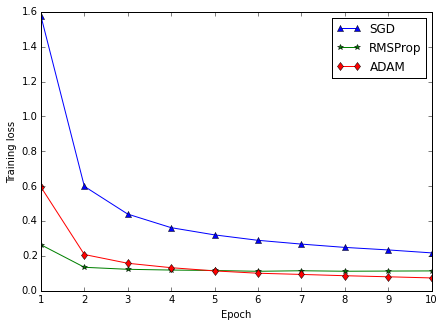

In [22]:
#Plot the cost history

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7,5))
x = range(1,11)
plt.plot(x, sgd_cost_history, 'b-^')
plt.plot(x, rmsprop_cost_history, 'g-*')
plt.plot(x, adam_cost_history, 'r-d')

plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend(['SGD','RMSProp','ADAM'])
plt.savefig('training_loss.png')

## Test the models

In [23]:
def get_error(val_fn):
    loss, acc = val_fn(x_test, y_test)
    test_error = 1 - acc
    return test_error

In [24]:
print "Model trained with SGD. Test error: %f" % get_error(sgd_functions[1])
print "Model trained with RMSProp. Test error: %f" % get_error(rmsprop_functions[1])
print "Model trained with ADAM. Test error: %f" % get_error(adam_functions[1])

Model trained with SGD. Test error: 0.031500
Model trained with RMSProp. Test error: 0.018300
Model trained with ADAM. Test error: 0.013900
